# Part 1: Stochastic Cellular Model with Markov Chain

The model in Part 0 is a deterministic cellur model, which means once the forest is formed and the fire location is determined, the results are fixed. However, in this model, stochastic model is added. It is modeled as a random ohenomenon on a regular spatial grid, specially, an interacting pacrticle system modeled as a continuous-time Markov chain on a latice.

Assuming a $n*m$ grid with 1 to represent forest area and 0 to represent non-forest area. The cell (i,j) can past the fire to four directions (i+1,j), (i-1,j), (i,j+1),(i,j-1) in random amounts of time $T_{1,0}$,$T_{-1,0}$, $T_{0,1}$,$T_{0,-1}$. The forest itself can be burning in random ampunt of time $T_{0,0}$. Each duration, T, is assumed to be indepenedent and exponentially distributed with mean $1/\lambda$

Each node can have four status, non-forest:0 in black, forest:1 in green, burning:2 in red, and burned:3 in grey.

# #Exercise 1: Fire without wind

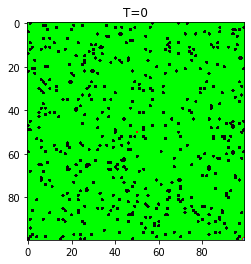

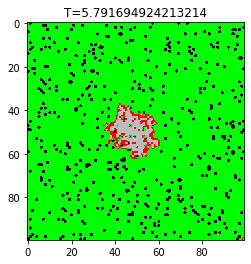

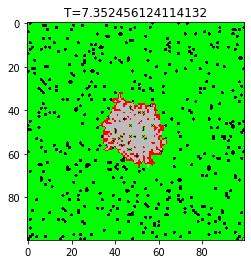

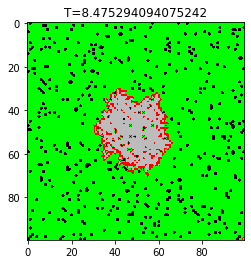

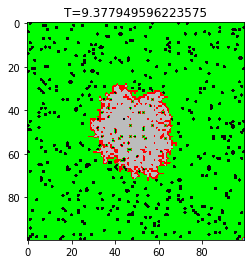

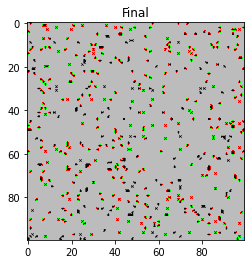

In [1]:
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import heapq

# Define the colors we want to use
blue = np.array([12/256, 238/256, 246/256, 1])
black = np.array([11/256, 11/256, 11/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])
red = np.array([1, 0, 0, 1])
green=np.array([0,1,0,1])

mapping = np.linspace(-1,4,256)
newcolors = np.empty((256, 4))
newcolors[mapping <=4] = blue
newcolors[mapping <= 3] = grey
newcolors[mapping <= 2] = red
newcolors[mapping <= 1] = green
newcolors[mapping <= 0] = black

# Make the colormap from the listed colors
my_colormap = ListedColormap(newcolors)

def gen_forest(m,n,p):
    Graph=np.zeros([m,n],int)
    forest_ratio=p
    for i in range(m):
        for j in range(n):
            rd=np.random.randint(0,100)/100
            if rd<forest_ratio:
                Graph[i][j]=1
            else:
                Graph[i][j]=0
    Graph[-1][-1]=4
    return Graph

def set_fire(x,y,Graph):
    Graph[x][y]=1
    fire=(x,y)
    fire_list=[(0,2,fire[0],fire[1])]  #timestamp, status, x, y
    return fire_list 
    
def get_dur():
    dur0=np.random.exponential(1)  #spread time
    dur1=np.random.exponential(1)
    dur2=np.random.exponential(1)
    dur3=np.random.exponential(1)
    dur4=np.random.exponential(1/2)   #burning time
    return [dur0,dur1,dur2,dur3,dur4]
    
def forest_fire(m,n,p):
    Graph=gen_forest(m,n,p)  #generate the forest with the forest ratio=p, here we use p=0.95
    fire_list=set_fire(m//2,n//2,Graph)  #set fire at the center of the forest
    directions=[(-1,0),(1,0),(0,1),(0,-1)]   #s,n,e,w
    iter,T=0,0
    #start the fire spread in the priority queue based on their time stamp
    while fire_list:
        iter+=1
        T,status,x,y=heapq.heappop(fire_list)
        dur=get_dur()
        #for the burning area
        if status==2:
            Graph[x][y]=2
            #next step is burned out in dur[0]
            heapq.heappush(fire_list,(T+dur[0],3,x,y))
            #spread the fire to its fore neighbors
            for (i,dir) in enumerate(directions):
                nx,ny=x+dir[0],y+dir[1]
                if 0<=nx<m and 0<=ny<n and Graph[nx][ny]==1:
                    heapq.heappush(fire_list,(T+dur[i],2,nx,ny))
        #for the burned area
        elif status==3:
            Graph[x][y]=3
        if iter%1000==1 and iter<5000:
            plt.figure()
            plt.imshow(Graph,cmap= my_colormap)
            plt.title("T="+str(T))
    plt.figure()
    plt.imshow(Graph,cmap= my_colormap)
    plt.title("Final")
    
forest_fire(100,100,0.95)
plt.show()

The results show that the fire spreads to its neighour randomly but remains radiul. The node in black is the non-forest area. The node in green is the forest area. The node in red is the burning area. The node in grey is the burned area. According to the results, we can see that while the fire spreading outside, there are still regions that are burning, which is what the fire should be in the real world. Therefore, this model is more closed to the real forest fire than the pure cellular model.

# #Exercise 2: Fire with Wind

Now, we will introdue the wind to the model. The wind has a magnitude ,W, and a direction, $\theta$. The wind will influece the time that the fire pass from one site to its neighors. Basically, the magnitude of the wind in the North-South, $W*sin\theta$ will scale the mean value of the $T_{1,0}, T_{-1,0}$'s exponential distribution. Meanwhile, the magnitude of the wind in the West-East,  $W*cos\theta$ will scale the mean value of the $T_{0,1}, T_{0,-1}$'s exponential distribution. 

Here, we simulate a wind in North-East direction. It's shown in the results that the fire spreads to the North-East direction much faster than the other directions.

Noth Wind in level 2 intensity


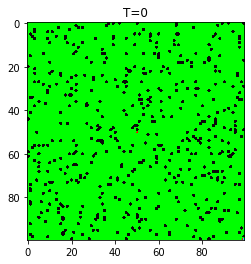

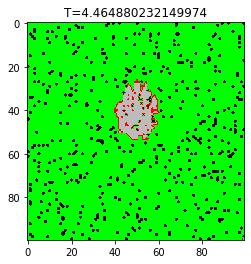

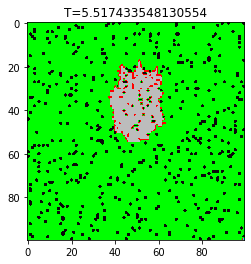

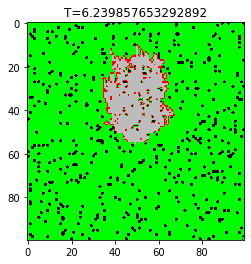

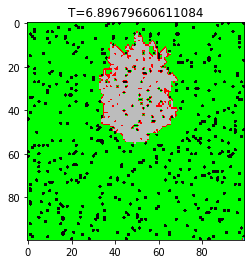

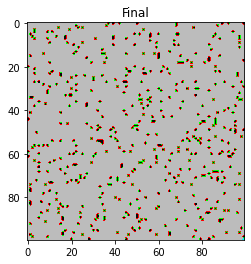

In [14]:
def get_wind(wind_M,wind_theta):
    theta=wind_theta/180*np.pi
    ns=wind_M*np.sin(theta)
    if ns<0:ns=1/(0-ns)
    ew=wind_M*np.cos(theta)
    if ew<0:ew=1/(0-ew)
    if wind_theta in {0,180}:ns=1
    elif wind_theta in {90,270}:ew=1
    if wind_M==0:
        ns=1
        ew=1
    wind=[1/ns,ns,1/ew,ew]
    dur0=np.random.exponential(1)*wind[0]  #spread time
    dur1=np.random.exponential(1)*wind[1]
    dur2=np.random.exponential(1)*wind[2]
    dur3=np.random.exponential(1)*wind[3]
    dur4=np.random.exponential(1/2)   #burning time
    return [dur0,dur1,dur2,dur3,dur4]
    
def forest_fire_wind(m,n,p,wind_M,wind_theta):        
    Graph=gen_forest(m,n,p)
    fire_list=set_fire(m//2,n//2,Graph)
    directions=[(-1,0),(1,0),(0,1),(0,-1)]   #s,n,e,w
    iter,T=0,0
    while fire_list:
        iter+=1
        T,status,x,y=heapq.heappop(fire_list)
        dur=get_wind(wind_M,wind_theta)
        if status==2:
            Graph[x][y]=2
            heapq.heappush(fire_list,(T+dur[0],3,x,y))
            for (i,dir) in enumerate(directions):
                nx,ny=x+dir[0],y+dir[1]
                if 0<=nx<m and 0<=ny<n and Graph[nx][ny]==1:
                    heapq.heappush(fire_list,(T+dur[i],2,nx,ny))
        elif status==3:
            Graph[x][y]=3
        if iter%1000==1 and iter<5000:
            plt.figure()
            plt.imshow(Graph,cmap= my_colormap)
            plt.title("T="+str(T))
    plt.figure()
    plt.imshow(Graph,cmap= my_colormap)
    plt.title("Final")

print("Noth Wind in level 2 intensity")
forest_fire_wind(100,100,0.95,5,90)

Southwest Wind in level 5 intensity


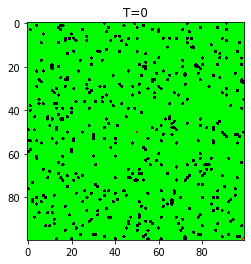

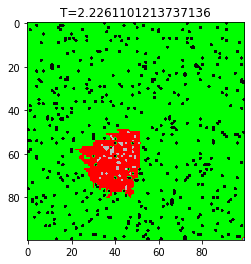

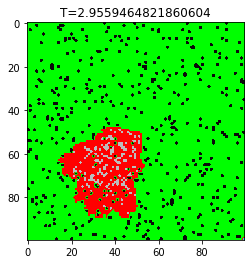

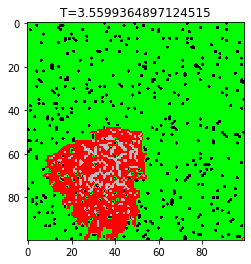

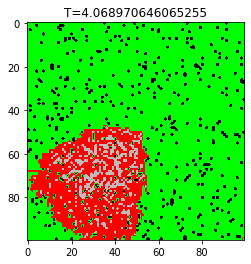

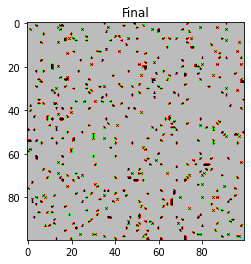

In [8]:
print("Southwest Wind in level 5 intensity")
forest_fire_wind(100,100,0.95,10,235)


Here, we generate two forest fires, one with level 2 wind in north and the other one with level 10 wind in southeast. From the figures showing the procedure, we can see that the wind direction does influence the spreading direction of the fire. Additionally, the magnitude of the wind will influence the speed of the fire. With small magnitude, level=2, in the region that is involved in the fire, only the edges of the forest is in fire. However, with large magnitude, level=10, most of the area involved in the fire is in red, which means the fire spread so fast that the fire center doesn't have time to burn out.

# #Exercise 3: Fire with Wind and Water

Next, we add a pool and a river into the forest. Without loss of generalosity, we generate a pool to the south of the fire center, and genrate a river flowing from the northwest to the southeast in the forest. In reality, the humidity near the water is much higher than the dry area, which makes it hard to burn. Even if it is burned, the fire lasting time is much shorter in these areas. We add this effect into the code by checking if an area is near the pool or the river. If it is near, we increase the spreading period from its neighbor and its burning time for itself.

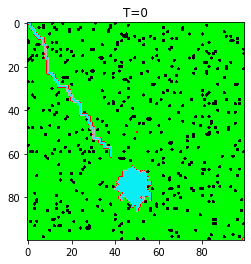

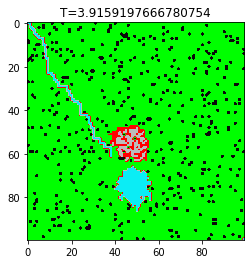

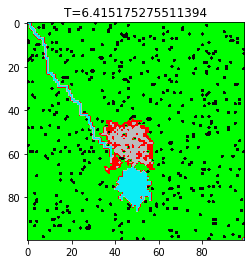

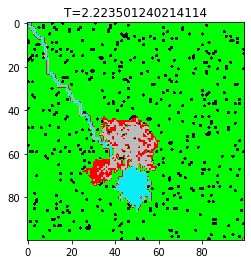

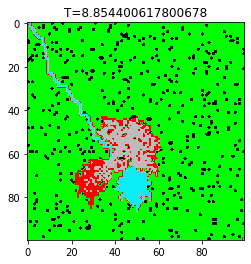

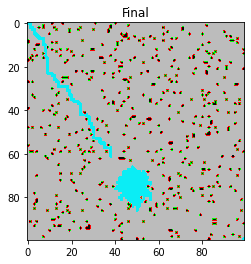

In [12]:
def pool_gen(Graph,area):
    m,n=len(Graph[0]),len(Graph)
    candidates={(3*n//4,m//2)}
    while area>0:
        i,j=candidates.pop()
        Graph[i][j]=4
        if (0<=i+1<n and 0<=j<m and Graph[i+1][j]!=4):candidates.add((i+1,j))
        if (0<=i-1<n and 0<=j<m and Graph[i-1][j]!=4):candidates.add((i-1,j))
        if (0<=i<n and 0<=j+1<m and Graph[i][j+1]!=4):candidates.add((i,j+1))
        if (0<=i<n and 0<=j-1<m and Graph[i][j-1]!=4):candidates.add((i,j-1))
        area-=1
        
def river_gen(Graph,area):
    m,n=len(Graph[0]),len(Graph)
    head=(0,0)
    while area>0:
        i,j=head[0],head[1]
        Graph[i][j]=4
        rd=np.random.randint(0,10)
        if rd<=5:
            head=(i+1,j)
        else:
            head=(i,j+1)
        area-=1
        
def near_water(Graph,x,y):
    n,m=len(Graph),len(Graph[0])
    distances={1,2,3,4,5}
    directions={(1,0),(-1,0),(0,1),(0,-1)}
    for dis in distances:
        for dir in directions:
            nx,ny=x+dis*dir[0],y+dis*dir[1]
            if 0<=nx<n and 0<=ny<m and Graph[nx][ny]==4:return True
    return False
    
def forest_fire_wind_water(m,n,p,wind_M,wind_theta,pool_ratio,river_ratio):
    Graph=gen_forest(m,n,p)
    #geneate a pool whose area is some ratio of the forest
    pool_gen(Graph,int(pool_ratio*m*n))
    #geneate a river whose area is some ratio of the forest
    river_gen(Graph,int(river_ratio*m*n))
    fire_list=set_fire(m//2,n//2,Graph)
    directions=[(-1,0),(1,0),(0,1),(0,-1)]   #s,n,e,w
    iter,T,Tmax=0,0,0
    while fire_list:
        iter+=1
        T,status,x,y=heapq.heappop(fire_list)
        dur=get_wind(wind_M,wind_theta)
        if status==2:
            Graph[x][y]=2
            #check if the point is near the water, if it is near, the fire lasting locally is shorten
            if near_water(Graph,x,y):
                heapq.heappush(fire_list,(0.1*T+dur[0],3,x,y))
            else:
                heapq.heappush(fire_list,(T+dur[0],3,x,y))
            for (i,dir) in enumerate(directions):
                nx,ny=x+dir[0],y+dir[1]
                if 0<=nx<m and 0<=ny<n and Graph[nx][ny]==1:
                    #check if the point is near the water, it it is near, the time spread to this point is increased
                    if near_water(Graph,nx,ny):
                        heapq.heappush(fire_list,(T+10*dur[i],2,nx,ny))
                    else:
                        heapq.heappush(fire_list,(T+dur[i],2,nx,ny))
        elif status==3:
            Graph[x][y]=3
        if iter%500==1 and iter<2500:
            plt.figure()
            plt.imshow(Graph,cmap= my_colormap)
            plt.title("T="+str(T))
    plt.figure()
    plt.imshow(Graph,cmap= my_colormap)
    plt.title("Final")

forest_fire_wind_water(100,100,0.95,5,235,0.02,0.01)

Here, we genrate a pool with 2% of the forest and a river with 1% of the forest. The fire is set with a southeast wind in level 5. From the firing procedure figures, we can see that the spread of the fire becomes slow when it is near the water, blue area. In other words, the pool and the river influence the spread of the fire, which makes the simulated fire closer to the reality.

# #Exercise 4: Fire with Wind and Water and Extinguishment

In the real world, the most concern for the forest fire is about the extinguishment. Here, we simulate the forest fire as the extinguishment is done by the scanning of helicopters. The fire is first found by people in the time stamp: "startT". The helicopters cruise in the west-east direction. The cruise period for the helicopter is: "periodT", which means every "periodT" time, the helicopter appears above a certain area. For each helicopter, it pours the water into a certain area, which lasts for time: "lastingT".

0.2629

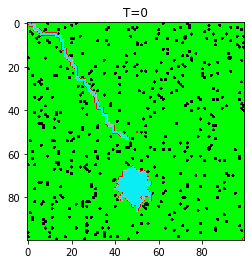

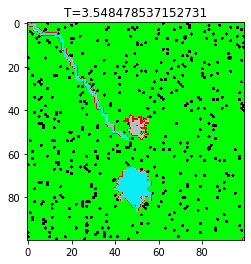

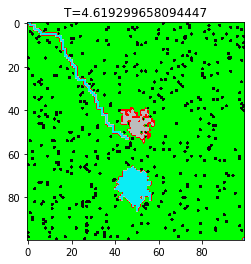

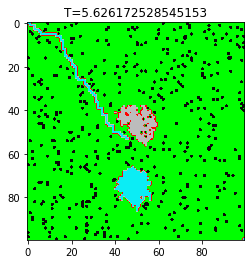

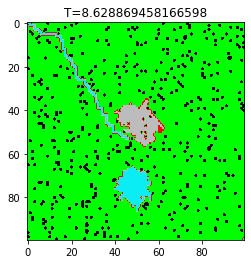

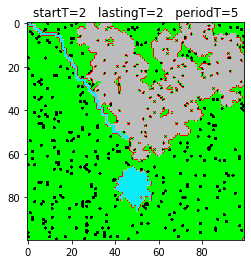

In [16]:
def extinguish(x,y,T,startT,lastingT,periodT):
    if T>startT and T%periodT<lastingT:return True
    else:return False
    
def get_burned_ratio(Graph,n,m):
    area=0
    for i in range(n):
        for j in range(m):
            if Graph[i][j]==3:
                area+=1
    return area/(m*n)

def forest_fire_wind_water_extinguish(m,n,p,wind_M,wind_theta,pool_ratio,river_ratio,startT,lastingT,periodT,printPro):        
    Graph=gen_forest(m,n,p)
    pool_gen(Graph,int(0.02*m*n))
    river_gen(Graph,int(0.01*m*n))
    fire_list=set_fire(m//2,n//2,Graph)
    directions=[(-1,0),(1,0),(0,1),(0,-1)]   #s,n,e,w
    iter,T,Tmax=0,0,0
    while fire_list:
        iter+=1
        T,status,x,y=heapq.heappop(fire_list)
        Tmax=max(T,Tmax)
        dur=get_wind(wind_M,wind_theta)
        if status==2:
            if extinguish(x,y,T,startT,lastingT,periodT):Graph[x][y]=3
            else:
                Graph[x][y]=2
                if near_water(Graph,x,y):
                    heapq.heappush(fire_list,(0.1*T+dur[0],3,x,y))
                else:
                    heapq.heappush(fire_list,(T+dur[0],3,x,y))
                for (i,dir) in enumerate(directions):
                    nx,ny=x+dir[0],y+dir[1]
                    if 0<=nx<m and 0<=ny<n and Graph[nx][ny]==1:
                        if near_water(Graph,nx,ny):
                            heapq.heappush(fire_list,(T+10*dur[i],2,nx,ny))
                        else:
                            heapq.heappush(fire_list,(T+dur[i],2,nx,ny))
        elif status==3:
            Graph[x][y]=3
        if printPro:
            if iter%200==1 and iter<1000:
                plt.figure()
                plt.imshow(Graph, cmap=my_colormap)
                plt.title("T="+str(T))
    if printPro:
        plt.figure()
        plt.imshow(Graph, cmap=my_colormap)
        plt.title("startT="+str(startT)+"   lastingT="+str(lastingT)+"   periodT="+str(periodT))
    burned_ratio=get_burned_ratio(Graph,n,m)
    return burned_ratio 
        
forest_fire_wind_water_extinguish(100,100,0.95,0,0,0.02,0.01,startT=2,lastingT=2,periodT=5,printPro=True)

Here, we genrates the fire with no wind. Due to the existence of the pool and the water, the fire is stuck in the west and south directions, but spread to the north and east directions. With the extingshment starts at 2 timeunit, appears every 5 timeunit, lasting for 2 timeunit for each one, the fire is finally put out. The total burned area is 26.29% of the forest. 

The influnce of the staring time, period, lasting time of the extinguishment on the ratio of the burned area is tested above. 

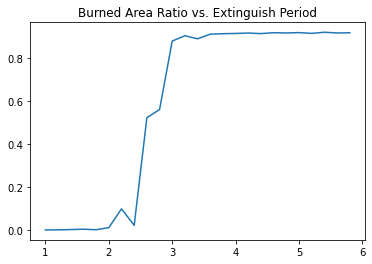

In [23]:
def burned_area_exting_period():
    burned_areas=[]
    periods=np.arange(1,6,0.2)
    for period in periods:
        burned_areas.append(forest_fire_wind_water_extinguish(100,100,0.95,0,0,0.02,0.01,1,1,period,False))
    plt.figure()
    plt.plot(periods,burned_areas)
    plt.title("Burned Area Ratio vs. Extinguish Period")
    
burned_area_exting_period()

With the increase of the extinguishment period, the frequency of the extinguishment drops, which makes the fire hard to put out.There is a critcal point of the extinguishment period about 2 to 3. Below this extinguishment period, the fire can be put out with burned area ratio closed to ratio. Above it, the fire can't be put out with burned area ratio closed to original forest ratio 0.95.   

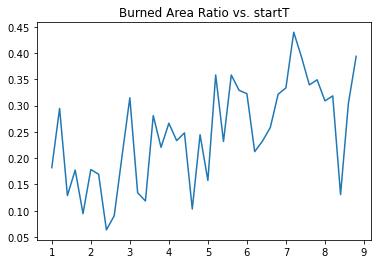

In [20]:
def burned_area_startT():
    burned_areas=[]
    startTs=np.arange(1,9,0.2)
    for startT in startTs:
        burned_areas.append(forest_fire_wind_water_extinguish(100,100,0.95,0,0,0.02,0.01,startT,2,5,False))
    plt.figure()
    plt.plot(startTs,burned_areas)
    plt.title("Burned Area Ratio vs. startT")
burned_area_startT()

With the change of the starting time of the extinguishment, the final burned area is not influnced much, which actually fluctates with respect to the starting time. It is reasonable, since we don't take the total area of extinguishment into concern. In other words, no matter how much region is involved in the fire, we always apply the extinguishment to the total graph, the whole forest, which is a waste of resources. 


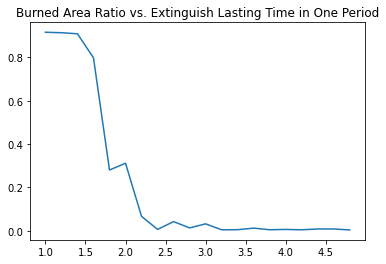

In [22]:
def burned_area_lastingT():
    burned_areas=[]
    lastingTs=np.arange(1,5,0.2)
    for lastingT in lastingTs:
        burned_areas.append(forest_fire_wind_water_extinguish(100,100,0.95,0,0,0.02,0.01,2,lastingT,5,False))
    plt.figure()
    plt.plot(lastingTs,burned_areas)
    plt.title("Burned Area Ratio vs. Extinguish Lasting Time in One Period")
burned_area_lastingT()

With the change of the lasting time, the final burned area decreases with lasting time. As long as the lasting time reaches the period, the extinguishment takes place for all time for all area, which is not possible, which is 5 in the figure. However, the lasting time doesn't need to reach that large. The fire can be put out with the lasting time equals to 2 timeunit, as shown in the figure, which is very helpful information when determine the number of helicopters that are needed during the extinguishment.  